In [1]:
import time 
import torch
import cv2
import argparse
import torchvision
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt 

from pathlib import Path
from tqdm import tqdm 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import JaccardIndex
from torchmetrics.classification import BinaryStatScores

import gmlp_cross as gmlp 
import nafnet
import constants
from dataset import HierText

torch.manual_seed(27)
torch.cuda.manual_seed_all(27)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
args = {}
args['train_data_dir'] = '../data/train'
args['val_data_dir'] = '../data/validation'
args['binary_data_dir'] = '../data/binary_train'
args['val_binary_data_dir'] = '../data/binary_val'
args['csv_file'] = '../data/gt/hiertext.csv'
args['val_csv_file'] = '../data/gt/val_hiertext.csv'

args['transform'] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((constants.IMAGE_SIZE, constants.IMAGE_SIZE)),
        transforms.ToTensor()
    ])

train_dataset = HierText(csv_file=Path(args['csv_file']), data_dir=Path(args['train_data_dir']), binary_data_dir=Path(args['binary_data_dir']), transform=args['transform'])
val_dataset = HierText(csv_file=Path(args['val_csv_file']), data_dir=Path(args['val_data_dir']), binary_data_dir=Path(args['val_binary_data_dir']), transform=args['transform'])

train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=constants.NUM_WORKERS, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=constants.NUM_WORKERS, shuffle=False, pin_memory=True)

In [4]:
model = gmlp.DVQAModel().to(device)

model_save_path = '../out/1680693879/checkpoints/model.pth'

checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model'])
m = nn.Sigmoid()

  0%|                                                                                             | 0/1724 [00:00<?, ?batch/s]

torch.Size([1, 1024, 1024])
<class 'numpy.ndarray'>
(1024, 1024)
162
[[[501 984]]

 [[502 984]]]
*********
{'m00': 0.0, 'm10': 0.0, 'm01': 0.0, 'm20': 0.0, 'm11': 0.0, 'm02': 0.0, 'm30': 0.0, 'm21': 0.0, 'm12': 0.0, 'm03': 0.0, 'mu20': 0.0, 'mu11': 0.0, 'mu02': 0.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.0, 'nu11': 0.0, 'nu02': 0.0, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
[[[690 970]]

 [[690 971]]]
*********
{'m00': 0.0, 'm10': 0.0, 'm01': 0.0, 'm20': 0.0, 'm11': 0.0, 'm02': 0.0, 'm30': 0.0, 'm21': 0.0, 'm12': 0.0, 'm03': 0.0, 'mu20': 0.0, 'mu11': 0.0, 'mu02': 0.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.0, 'nu11': 0.0, 'nu02': 0.0, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
[[[531 959]]]
*********
{'m00': 0.0, 'm10': 0.0, 'm01': 0.0, 'm20': 0.0, 'm11': 0.0, 'm02': 0.0, 'm30': 0.0, 'm21': 0.0, 'm12': 0.0, 'm03': 0.0, 'mu20': 0.0, 'mu11': 0.0, 'mu02': 0.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.0, 

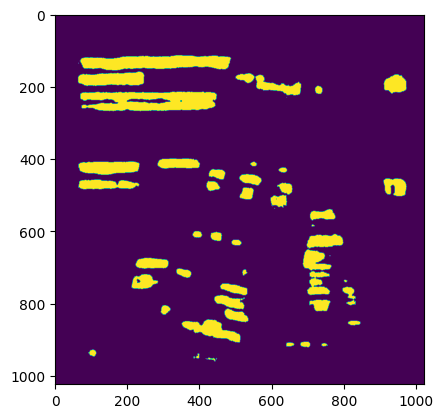

  0%|                                                                                             | 0/1724 [00:02<?, ?batch/s]


In [21]:
with torch.no_grad():
    with tqdm(val_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            image = batch['image'].to(device)
            binary_image = batch['binary_image'].to(device)

            outputs = model(image)
            outputs = m(outputs)
            outputs[outputs>=0.5]=255.0
            outputs[outputs<0.5]=0.0
            binary_image[binary_image>=0.5]=255.0
            binary_image[binary_image<0.5]=0.0
            print(binary_image.shape)
            
            b_im = binary_image.cpu().detach().numpy()
            op = outputs.cpu().detach().numpy()
            
            print(type(b_im))
            print(b_im[0].shape)
            
            contours, hierarchy = cv2.findContours(b_im[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#             contours, hierarchy = cv2.findContours(op[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
#             plt.imshow(cv2.drawContours(b_im[0].astype(np.uint8), contours, -1, (0,255,0), 3))
#             plt.show()
#             plt.imshow(cv2.drawContours(op.astype(np.uint8), contours, -1, (0,255,0), 3))
#             plt.show()
            print(len(contours))
            for i in contours:
                M = cv2.moments(i)
                print(i)
                print('*********')
                print(M)
                if M['m00'] == 0:
                    continue
                else:
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                    
                    cv2.drawContours(op.astype(np.uint8), [i], -1, (0, 255, 0), 2)
                    cv2.circle(op.astype(np.uint8), (cx, cy), 7, (0, 0, 255), -1)
                    cv2.putText(op.astype(np.uint8), "center", (cx - 20, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
                print(f"x: {cx} y: {cy}")
                print("ab")
            plt.imshow(op.astype(np.uint8))
            plt.show()
            break